<a href="https://colab.research.google.com/github/nicollasro/Echochamber/blob/main/Processamento_de_C%C3%A2maras_de_Eco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Etapa 1.0 - Clonando GIT e Instalando Bibliotecas**

In [1]:
#!pip install pingouin
#!pip install infomap
!git clone https://github.com/nicollasro/Echochamber.git
!pip install pecanpy
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 3.8 MB/s 
     |████████████████████████████████| 9.9 MB 51.0 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196206 sha256=aa2580523ab39a5b75dc86b6670937d1105895c5db04b82b4645a542766e11f2
  Stored in directory: /root/.cache/pip/wheels/11/5a/63/a6d32fc26fa462c731f65480bfb98ff7bd39b8ebcb4bc6c2fe
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=63a8fd44839cf9c6767443f0ef49f8a55bf1e48a19e6cb27db4a41899b1cf53e
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built pingouin littleutils
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
Looking in indexes: https://pypi.org/simple

**Etapa 1.1 - Importação das Bibliotecas**


In [3]:
import os
import itertools
import numpy as np
import igraph as ig

import pandas as pd
import networkx as nx
#import pingouin as pg

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors as mcolors

#from hopkins import hopkins_statistic
#from math import sqrt
from pylab import rcParams
#from collections import Counter
#from sklearn import preprocessing
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


**Etapa 2.0 - Construindo o Grafo:** Usando a Biblioteca Networkx

In [ ]:
filepath_e = "/content/Echochamber/politics_2019-01-01_2019-07-01_edgelist.csv"
filepath_n = "/content/Echochamber/politics_2019-01-01_2019-07-01_nodelist.csv"
df = pd.read_csv(filepath_e,header=0)
print(df)
G = nx.from_pandas_edgelist(df,'from_id', 'to_id', ['weight'])

**Etapa 2.1 - Plotando o Grafo Gerado:** Usando a Biblioteca Matplotlib

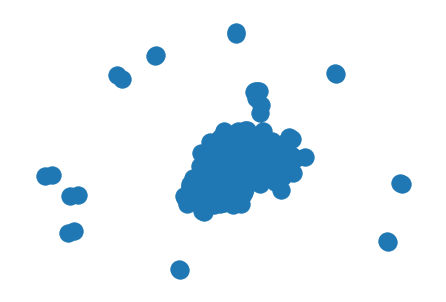

In [12]:
pos = nx.fruchterman_reingold_layout(G)
labels = nx.get_edge_attributes(G,'weight')
nx.draw(G,pos, with_labels=False, font_weight='bold')
plt.show()

**Etapa 2.2 - Remoção de Subgrafos Desconexos:** Removendo Componentes Isoladas

In [13]:
for component in list(nx.connected_components(G)):
    if len(component)<20: #Removendo subgrafos desconexos do principal com menos de 20 nós
        for node in component:
            G.remove_node(node)

**Etapa 2.3 - Plotando o Subgrafo Principal:** Pós-Remoção de Componentes Isoladas 

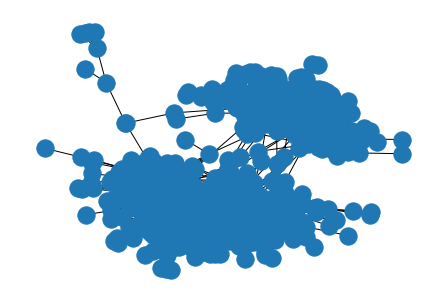

In [14]:
pos = nx.fruchterman_reingold_layout(G)
labels = nx.get_edge_attributes(G,'weight')
nx.draw(G,pos, with_labels=False, font_weight='bold')
plt.show()

**Etapa 3.0 - Métricas de Redes Complexas:** Métricas Gerais

In [16]:
print("Densidade: ", nx.density(G))
print("Diâmetro: ",nx.diameter(G))
print("Assortatividade (Grau): ", nx.degree_assortativity_coefficient(G))
print("transitividade): ", nx.transitivity(G))

Densidade:  0.006326627379258958
Diâmetro:  10
Assortatividade (Grau):  -0.20475688605978243
transitividade):  0.08091837336953314


**Etapa 3.1 - Métricas de Redes Complexas:** Centralidades

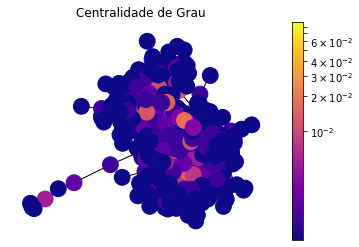

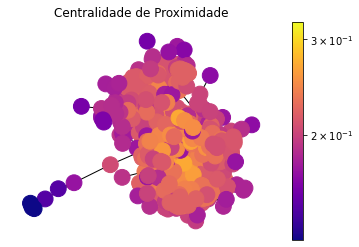

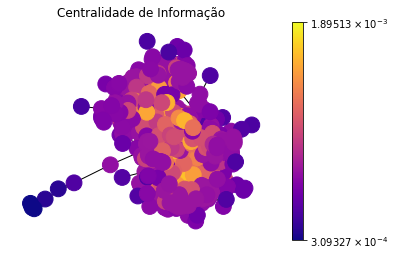

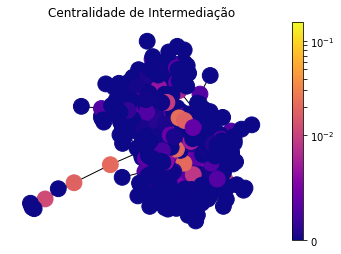

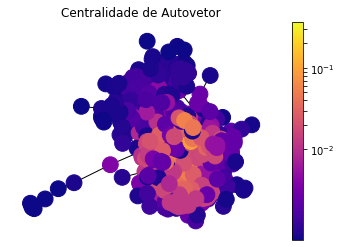

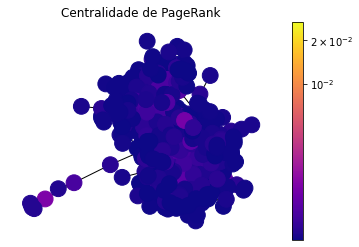

In [18]:
def draw(G, pos, measures, measure_name):
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

pos = nx.spring_layout(G, seed=675)
draw(G, pos, nx.degree_centrality(G), 'Centralidade de Grau')
draw(G, pos, nx.closeness_centrality(G), 'Centralidade de Proximidade')
draw(G, pos, nx.information_centrality(G), 'Centralidade de Informação')
draw(G, pos, nx.betweenness_centrality(G), 'Centralidade de Intermediação')
draw(G, pos, nx.eigenvector_centrality(G,max_iter=1000), 'Centralidade de Autovetor')
draw(G, pos, nx.pagerank(G,alpha=0.85), 'Centralidade de PageRank')

**Etapa 4.0 - Incorporação de Grafos:** Gerando o Arquivo de Entrada

In [10]:
nx.write_weighted_edgelist(G, "/content/Echochamber/input.edg", delimiter="	") 

**Etapa 4.1 - Incorporação de Grafos**: Executando o Pecanpy

In [11]:
!pecanpy --input /content/Echochamber/input.edg --output /content/Echochamber/output.emb --verbose --mode SparseOTF

Took 00:00:00.01 to load Graph
Took 00:00:00.00 to pre-compute transition probabilities
100% 6860.0/6860 [00:08<00:00, 850.94it/s]  
Took 00:00:08.16 to generate walks
Took 00:00:03.40 to train embeddings


**Etapa 5.0 - Construindo o Grafo:** Usando a Biblioteca igraph

In [19]:
#filepath_e = "/content/sample_data/politics_2019-01-01_2019-07-01_edgelist.csv"
#filepath_n = "/content/sample_data/politics_2019-01-01_2019-07-01_nodelist.csv"
#df = pd.read_csv(filepath_e,header=0)
#df2 = pd.read_csv(filepath_n,header=0)
#G = nx.from_pandas_edgelist(df,'from_id', 'to_id', ['weight'])
#print(df)
#print(df2)
g = ig.Graph.TupleList(df.itertuples(index=False), directed=False, weights=True)

**Etapa 6.0 - Detecção de Comunidade**: Executando Agoritmos de Detecção

In [29]:
communities_lpa = g.community_label_propagation()
print("Comunidades Geradas (Label Propagation):", len(communities_lpa))
communities_infomap = g.community_infomap()
print("Comunidades Geradas (Infomap):", len(communities_infomap))

Comunidades Geradas (Label Propagation): 36
Comunidades Geradas (Infomap): 70


**Etapa 6.1 - Detecção de Comunidade:** Plotando as Comunidades Geradas

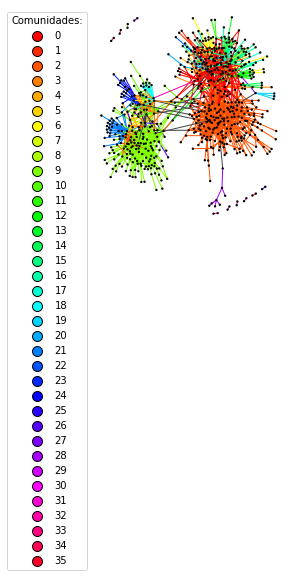

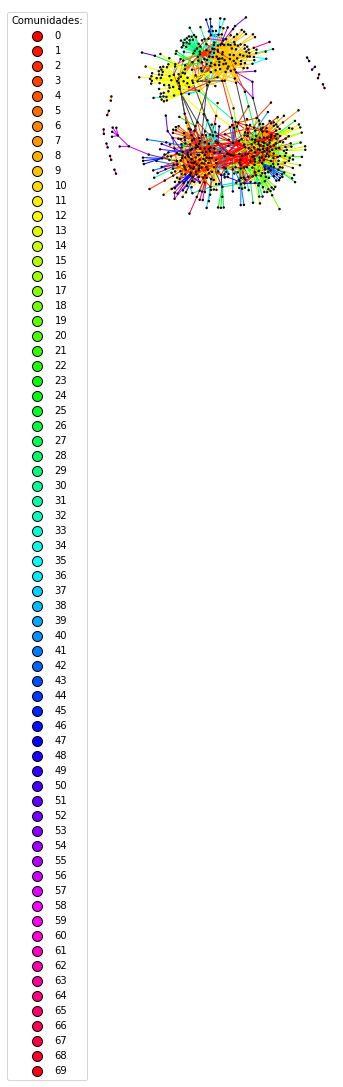

In [30]:
def plot_communities(communities):
  num_communities = len(communities)
  palette = ig.RainbowPalette(n=num_communities)
  for i, community in enumerate(communities):
    g.vs[community]["color"] = i
    community_edges = g.es.select(_within=community)
    community_edges["color"] = i
  fig, ax = plt.subplots()
  ig.plot(communities, palette=palette,edge_width=1,target=ax, vertex_size=0.3,)

  legend_handles = []
  for i in range(num_communities):
      handle = ax.scatter([], [],s=100,facecolor=palette.get(i),edgecolor="k",label=i,)
      legend_handles.append(handle)
  ax.legend(handles=legend_handles,title='Comunidades:',bbox_to_anchor=(0, 1.0),bbox_transform=ax.transAxes,)
  plt.show()


plot_communities(communities_lpa)
plot_communities(communities_infomap)

**Referências**
[1] Network Centrality Measures and Their Visualization. Link: https://aksakalli.github.io/2017/07/17/network-centrality-measures-and-their-visualization.html#pagerank

In [ ]:
dendrogram = g.community_fastgreedy()
dendrogram = g.community_walktrap()
clusters = dendrogram.as_clustering()
membership = clusters.membership
print(membership)

[0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 4, 4, 2, 2, 2, 2, 0, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 5, 4, 5, 0, 0, 0, 0, 6, 0, 0, 0, 4, 4, 0, 0, 5, 5, 2, 2, 2, 2, 2, 4, 4, 0, 0, 4, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 0, 2, 2, 2, 2, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 8, 8, 6, 5, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 9, 9, 10, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 2, 11, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 4, 4, 2, 2, 2, 2, 0, 2, 12, 12, 5, 2, 2, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 5, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 2, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 2, 0, 0, 4, 0, 0, 0, 0,